In [530]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as slm
import sklearn.model_selection as sms
import sklearn.metrics as sm
import sklearn.preprocessing as spp
import sklearn.pipeline as spl

In [531]:
# Read training data
LABEL_COLUMN = "Lead"
raw_data = pd.read_csv("train.csv")
raw_data

,Number words female,Total words,Number of words lead,Difference in words lead and co-lead,Number of male actors,Year,Number of female actors,Number words male,Gross,Mean Age Male,Mean Age Female,Age Lead,Age Co-Lead,Lead
0,1512,6394,2251.0,343,2,1995,5,2631,142.0,51.500000,42.333333,46.0,65.0,Female
1,1524,8780,2020.0,1219,9,2001,4,5236,37.0,39.125000,29.333333,58.0,34.0,Male
2,155,4176,942.0,787,7,1968,1,3079,376.0,42.500000,37.000000,46.0,37.0,Male
3,1073,9855,3440.0,2623,12,2002,2,5342,19.0,35.222222,21.500000,33.0,23.0,Male
4,1317,7688,3835.0,3149,8,1988,4,2536,40.0,45.250000,45.000000,36.0,39.0,Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,303,2398,1334.0,1166,5,1973,2,761,174.0,43.200000,31.000000,46.0,24.0,Male
1035,632,8404,1952.0,187,6,1992,2,5820,172.0,37.166667,24.000000,21.0,34.0,Female
1036,1326,2750,877.0,356,2,2000,3,547,53.0,27.500000,27.666667,28.0,25.0,Male
1037,462,3994,775.0,52,8,1996,3,2757,32.0,42.857143,38.500000,29.0,32.0,Female


In [532]:
print("Ratio of movies with female lead:", len(raw_data[raw_data["Lead"]=="Female"])/len(raw_data))

Ratio of movies with female lead: 0.24446583253128007


In [547]:
# Preprocess (TBD)
# - Scaling
# - Feature engineering

#scaler = spp.StandardScaler()
#scaled_data = pd.DataFrame(scaler.fit_transform(raw_data[raw_data.columns[:-1]]), columns=raw_data.columns[:-1])
#scaled_data["Lead"] = raw_data["Lead"]
#train_data = scaled_data

train_data = raw_data.copy()
#train_data["Number of actors"] = train_data["Number of female actors"] + train_data["Number of male actors"]
#train_data.insert(13, column="Ratio female", value = train_data["Number of female actors"] / (train_data["Number of male actors"] + train_data["Number of female actors"]))
#train_data["Year"] = train_data["Year"] - 1939
train_data

,Number words female,Total words,Number of words lead,Difference in words lead and co-lead,Number of male actors,Year,Number of female actors,Number words male,Gross,Mean Age Male,Mean Age Female,Age Lead,Age Co-Lead,Lead
0,1512,6394,2251.0,343,2,1995,5,2631,142.0,51.500000,42.333333,46.0,65.0,Female
1,1524,8780,2020.0,1219,9,2001,4,5236,37.0,39.125000,29.333333,58.0,34.0,Male
2,155,4176,942.0,787,7,1968,1,3079,376.0,42.500000,37.000000,46.0,37.0,Male
3,1073,9855,3440.0,2623,12,2002,2,5342,19.0,35.222222,21.500000,33.0,23.0,Male
4,1317,7688,3835.0,3149,8,1988,4,2536,40.0,45.250000,45.000000,36.0,39.0,Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,303,2398,1334.0,1166,5,1973,2,761,174.0,43.200000,31.000000,46.0,24.0,Male
1035,632,8404,1952.0,187,6,1992,2,5820,172.0,37.166667,24.000000,21.0,34.0,Female
1036,1326,2750,877.0,356,2,2000,3,547,53.0,27.500000,27.666667,28.0,25.0,Male
1037,462,3994,775.0,52,8,1996,3,2757,32.0,42.857143,38.500000,29.0,32.0,Female


In [548]:
# Train the model
def train(lr_model, dataset, K=10):

    scaler = spp.StandardScaler()
    #scaler = spp.FunctionTransformer(lambda x:x)
    model_with_scaling = spl.Pipeline([("scaler", scaler), ("lr", lr_model)])
    
    # Set up the CV grid search for lambda tuning
    lambda_exp_min = -2
    lambda_exp_max = 3
    lambda_range = {"lr__C":[1/(10**x) for x in np.linspace(lambda_exp_min, lambda_exp_max, 40)]}
    
    kf = sms.StratifiedKFold(n_splits=K, random_state=1, shuffle=True)
    
    grid_search = sms.GridSearchCV(estimator=model_with_scaling,
                                   param_grid=lambda_range,
                                   cv=kf,
                                   scoring="accuracy",
                                   refit=True,
                                   return_train_score=True)

    X_train = dataset.loc[:, dataset.columns != LABEL_COLUMN].values
    Y_train = dataset.loc[:, dataset.columns == LABEL_COLUMN].values.ravel()
    
    # Search for the best lambda, using 10-fold cross-valiation to evaluate each lambda value
    grid_search.fit(X_train, Y_train)
    
    # Return the results
    lambdas = grid_search.cv_results_["param_lr__C"].astype("float")
    train_scores = grid_search.cv_results_["mean_train_score"]
    test_scores = grid_search.cv_results_["mean_test_score"]
    weights = pd.DataFrame({"Feature":dataset.columns[:-1].values, "Weight":grid_search.best_estimator_.named_steps["lr"].coef_[0]})
    best_lambda = 1/grid_search.best_params_["lr__C"]
    best_score = grid_search.best_score_
    score_std = grid_search.cv_results_["std_test_score"][grid_search.best_index_]
    Y_pred=grid_search.decision_function(X_train)
    auc = sm.roc_auc_score(Y_train, Y_pred)
    
    return (lambdas, train_scores, test_scores, weights, best_score, score_std, auc, best_lambda)

In [549]:
def print_result(result):
    print("Optimal lambda:", result[7])
    print("Accuracy:", result[4], ", std", result[5])
    print("AUC:", result[6])
    print()    

In [550]:
def train_on_subset(model, train_data, features):
    features.append(LABEL_COLUMN)
    return train(lr_L1, train_data[features], K=10)

Results for the best L1 model:
Optimal lambda: 0.01
Accuracy: 0.8768297236743837 , std 0.015818635682735397
AUC: 0.8880886704448568



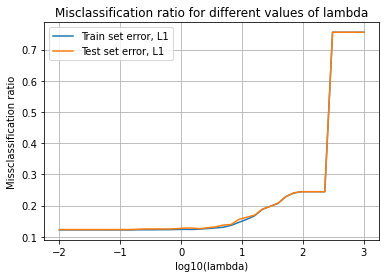

In [551]:
lr_L1 = slm.LogisticRegression(solver='liblinear', penalty='l1')

#result = train_on_subset(lr_L1, train_data, ["Number words female", "Number words male", "Total words", "Year", "Gross"])
#print_result(result)

result = train(lr_L1, train_data, 10)
print("Results for the best L1 model:")
print_result(result)
plt.plot(np.log10(1/result[0]), 1-result[1], label="Train set error, L1")
plt.plot(np.log10(1/result[0]), 1-result[2], label="Test set error, L1")

'''
lr_L2 = slm.LogisticRegression(solver='liblinear', penalty='l2')
result = train(lr_L2, train_data, K=10)
print("Results for the best L2 model:")
print_result(result)
plt.plot(np.log10(1/result[0]), 1-result[1], label="Train set error, L2")
plt.plot(np.log10(1/result[0]), 1-result[2], label="Test set error, L2")
'''
plt.legend()
plt.xlabel("log10(lambda)")
plt.ylabel("Missclassification ratio")
plt.title("Misclassification ratio for different values of lambda")
plt.grid()
plt.show()


In [552]:
result[3].sort_values(by="Weight", key=lambda w:-abs(w), ignore_index=True)

,Feature,Weight
0,Difference in words lead and co-lead,2.326453
1,Number of words lead,-1.990692
2,Number words female,1.990279
3,Number of female actors,-1.725766
4,Number of male actors,1.317052
5,Age Lead,0.774983
6,Age Co-Lead,-0.649661
7,Number words male,-0.553341
8,Mean Age Male,-0.218893
9,Total words,-0.135463


<h1>Results</h1>
<table align="left">
    <tr><td>Using all features without preprocessing</td><td>0.880 +/- 0.02</td></tr>
    <tr><td>Using all features with standardization</td><td>0.877 +/- 0.015</td></tr>
    <tr><td>Using all features without standardization plus ratio female</td><td>0.879 +/- 0.02</td></tr>
    <tr><td>Using all features with standardization plus ratio female</td><td>0.873 +/- 0.01</td></tr>
</table>